In [7]:
%pip install DeepFace

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install pymilvus

In [8]:
from deepface import DeepFace
import os
import glob

In [98]:
#models = ["VGG-Face", "Facenet", "Facenet512", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib"]

models = ["Facenet"]
files = glob.glob('./data/*')
embed = {}

images = {}
vectors = {}

id_ = 0
for image_path in files:
    vector = DeepFace.represent(img_path = image_path, model_name = "Facenet")
    images[id_] = image_path
    vectors[id_] = vector
    id_ += 1

dimension = len(vectors[0]) # Dimension of each record in milvus ; 128 for Facenet
m_vectors = list(vectors.values()) # m_ = milvus_
m_id = list(range(id_))

In [99]:
print("Total records:", len(m_vectors))
print("Dimensions:", dimension)

Total records: 17
Dimensions: 128


# Milvus

In [12]:
from pprint import pprint
import numpy as np
import random

from milvus import Milvus, IndexType, MetricType, Status

In [64]:
# Connecting to the host and port

host = '127.0.0.1'
port = '19530'
client = Milvus(host, port)

In [74]:
# Lists all the collections in use. Collections is similar to ElasticSearch tables
client.list_collections() 
# Empty list = No collections created so far

(Status(code=0, message='Show collections successfully!'), [])

In [75]:
collection_name = 'embeddings' # Tbale name
collection_param = {
    "collection_name": collection_name,
    "dimension": dimension,   # Length of the vector in every record
    "index_file_size": 2048,  # Maximum file size for every record in MBs
    "metric_type": MetricType.L2 # Metric to compare the distances, could be experimented
}

client.create_collection(collection_param) # Create new table

Status(code=0, message='Create collection successfully!')

In [76]:
client.list_collections()

(Status(code=0, message='Show collections successfully!'), ['embeddings'])

# Adding data to milvus

In [80]:
status, ids = client.insert(collection_name, m_vectors, m_id) # Added

In [82]:
status

Status(code=0, message='Add vectors successfully!')

In [81]:
client.flush([collection_name])

Status(code=0, message='OK')

## Get status

In [83]:
from pprint import pprint
status, stats = client.get_collection_stats(collection_name)
pprint(stats)

{'partitions': [{'row_count': 17,
                 'segments': [{'data_size': 8840,
                               'index_name': 'IDMAP',
                               'name': '1651230575236370000',
                               'row_count': 17}],
                 'tag': '_default'}],
 'row_count': 17}


# Search

In [144]:
target_img = "targetr.jpeg" # Address for target image
target = DeepFace.represent(target_img, model_name = "Facenet") # Generate embeddings for target image

In [145]:
status, results = client.search(collection_name, 5, [target])
# Will return top 5 results, '5' can be replaced
# The target vector must always be passed inside a list***

In [146]:
status

Status(code=0, message='Search vectors successfully!')

In [147]:
results # Lower distance = Better match

[
[
(id:7, distance:0.0),
(id:16, distance:144.6283416748047),
(id:13, distance:151.07545471191406),
(id:9, distance:163.55194091796875),
(id:15, distance:179.15481567382812)
]
]

In [148]:
outputs = []
for i in range(5):
    outputs.append(results[0][i].id)
    
outputs

[7, 16, 13, 9, 15]

# Display

Target


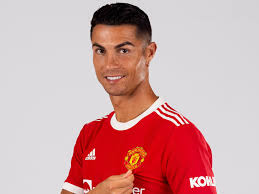

In [151]:
from IPython.display import Image, display
print("Target")
Image(filename='targetr.jpeg') 

Results


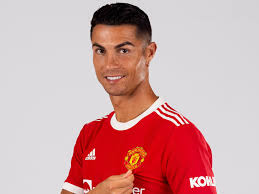

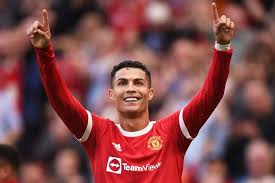

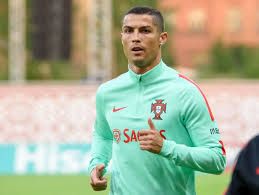

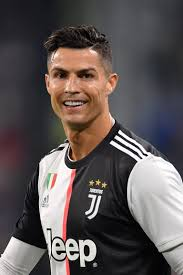

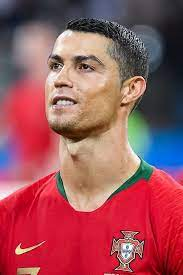

In [150]:
print("Results")
for output in outputs:
    display(Image(filename=images[output]))
